# Comparison notebook
In this notebook you can find how data has been generated, experiments launched and the results we used, as well as the analysis of the similarities and differences between the performances of a microservice prototype using asynchronous communication through rabbitmq, and the same microservice application simulated by SimGrid.

# Dependencies

In [48]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(tikzDevice)
library(gridExtra)
library(zoo)
library(ggpointdensity)
library(hexbin)

getwd()
# modify default plots size
options(repr.plot.width=15, repr.plot.height=7)
#setwd("yourpathifnecessary")

[1] "/home/clem/Code/github.com/klementc/calvin-microbenchmarks/comparison"

# Load generation

The load used for this experiment has been generated using the LIMBO synthethic load generator (https://research.spec.org/tools/overview/limbo.html) from which we extracted the timestamps. Below you can see the load for an experiment of 5 minutes, during which there are 3 spikes up to 30 reqs/sec. Timestamps can be found in `files/tsload.csv`

'data.frame':	4354 obs. of  1 variable:
 $ timestamp: num  0.462 0.489 0.731 0.88 1.219 ...


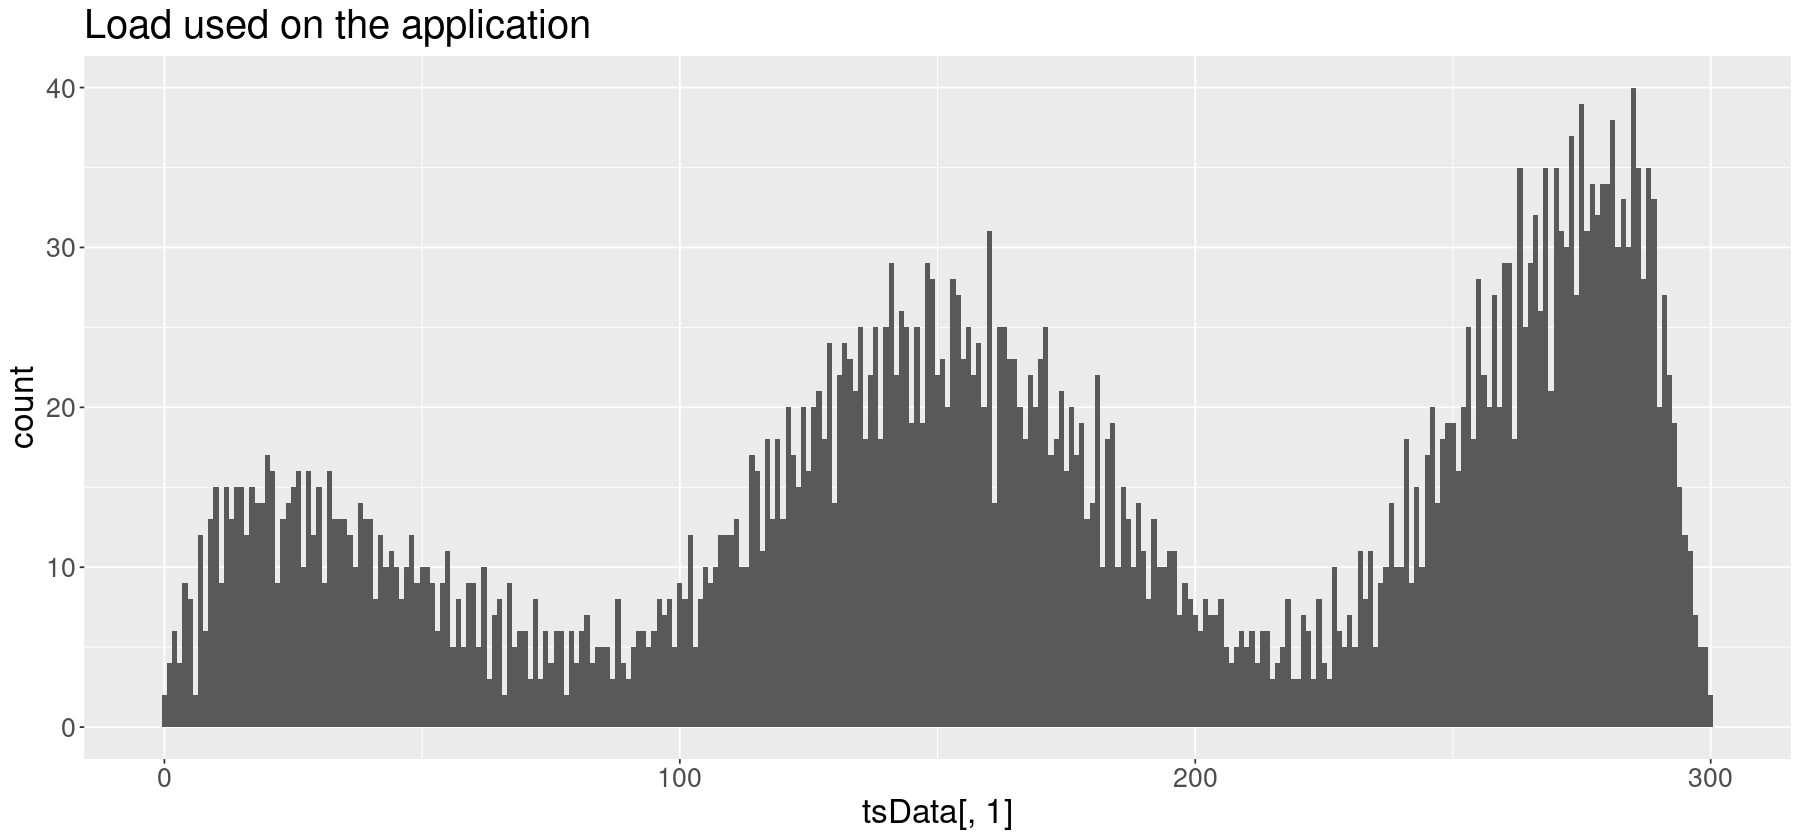

In [79]:
tsData <- read.csv("./files/tsload.csv")

colnames(tsData) <- c("timestamp")
str(tsData)

ggplot(tsData, aes(x=tsData[,1])) +
    geom_histogram(binwidth=1) +
    theme(text = element_text(size = 20)) + 
    ggtitle("Load used on the application")

# Compute the duration  of 1 request in the real world

To do that, use the simple `files/tsCal.csv` which contains 3 second spaced timestamps over 5 minutes. Files produced:

- `files/logcal_1_S1_1100000.log`
- `files/results_cal_1100000.csv`

## Without docker (not sure about usage of cores in this case)

```
# deploy the infrastructure
bash deployInfra.sh kill;logDir=logcal N1COST=1100000 bash deployInfra.sh 1
# in another terminal launch the datasource
python dataSourceService.py -r localhost -o computeTask -n source -t ../comparison/files/tsCal.csv
# once finished, parse logs
awk -f parse.awk logcal/1_S1_x.log > logcal/results_cal_1100000.csv
```

In [76]:
dataCalRW <- as_tibble(read.csv("files/results_cal_1100000.csv"))
head(dataCalRW)

ts,service,txDur,servDur,wait,nbIter
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
1614078512,compute,0.0024001598,0.03162217,0.0006175041,1100000
1614078515,compute,0.0026614666,0.03581524,0.0004987717,1100000
1614078518,compute,0.0008778572,0.02407241,0.0001318455,1100000
1614078521,compute,0.0011096001,0.02288985,0.0002117157,1100000
1614078524,compute,0.0024981499,0.03386021,0.0005421638,1100000
1614078527,compute,0.0021049976,0.06020308,0.0004808903,1100000


In [77]:
print("Stats of service duration:")
summary(dataCalRW["servDur"])

[1] "Stats of service duration:"


    servDur       
 Min.   :0.02289  
 1st Qu.:0.03042  
 Median :0.03261  
 Mean   :0.03499  
 3rd Qu.:0.03709  
 Max.   :0.06020  

**To get more precision, launch the same thing with more timestamps, but it seems enough here.
We end up with a median of 32ms (ON MY LAPTOP) for the execution of a request (1100000 loop iterations).**

Warning message:
“Removed 10 row(s) containing missing values (geom_path).”


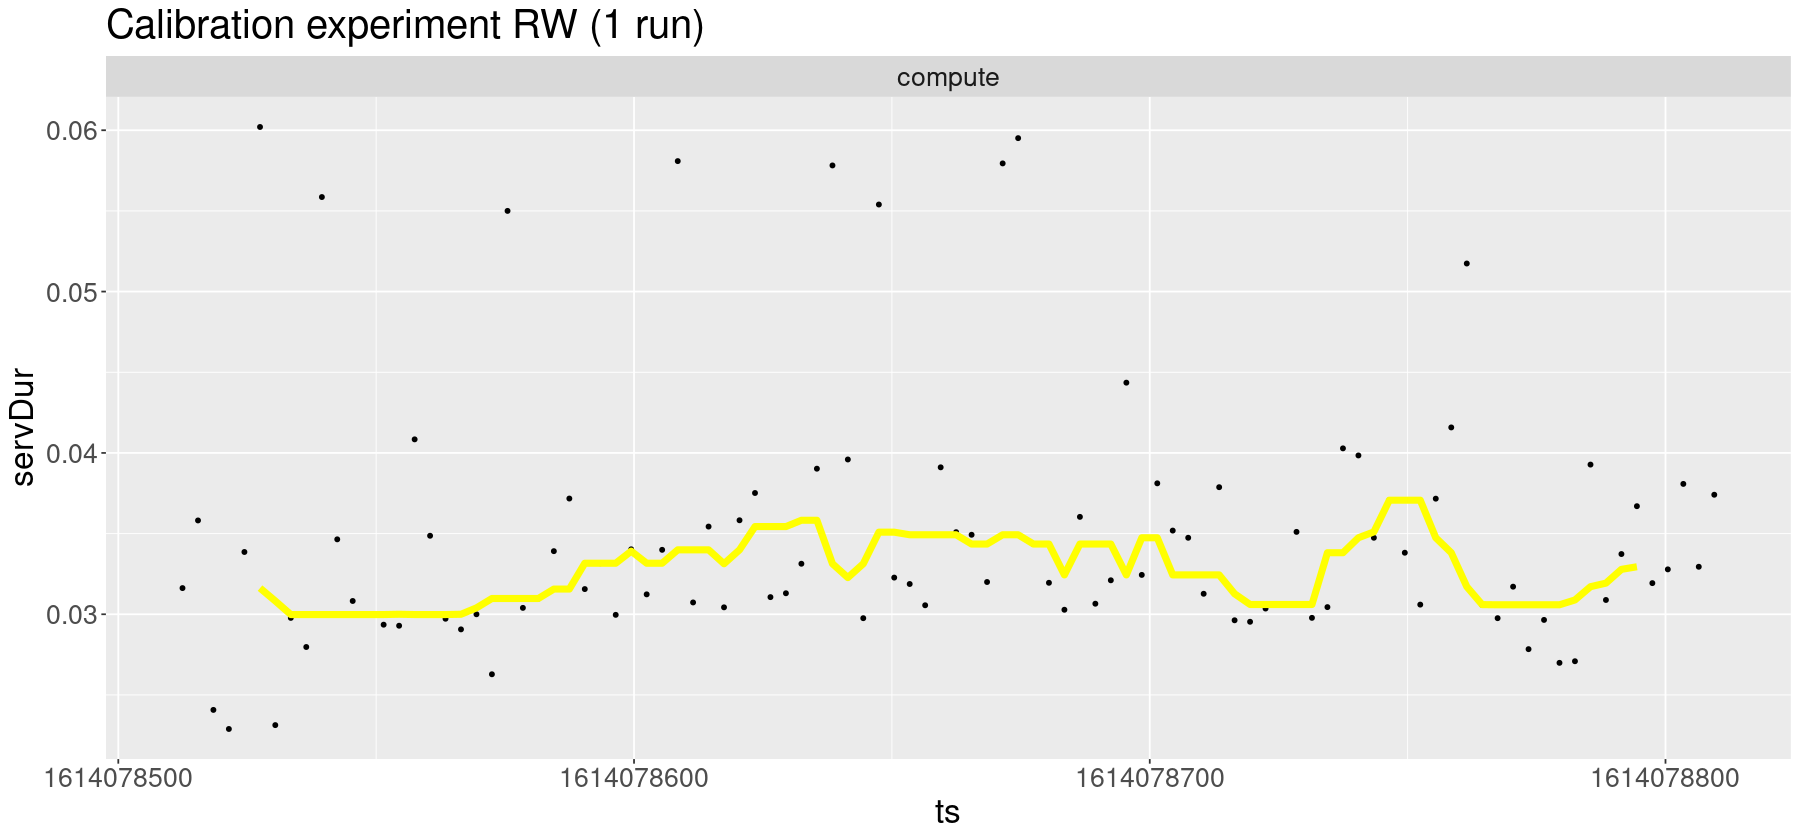

In [78]:
ggplot(dataCalRW, aes(x=ts, y=servDur))+
    geom_point(size=1)+
    #geom_line(color="blue")+
    facet_wrap("service", scales="free")+
    geom_line(aes(y=rollmedian(servDur, 11, na.pad=TRUE)), color="yellow", size=2)+
    theme(text = element_text(size = 20)) + 
    ggtitle("Calibration experiment RW (1 run)")

## With docker (and 1 core dedicated to the container)

### Run with only 1 cpu in a docker container to avoid multi core biases ?

Dockerfile:
```
FROM ubuntu

RUN apt-get update
RUN apt-get install -y python-setuptools python-dev build-essential python3-pip

RUN pip3 install --upgrade pip
RUN pip3 install jaeger-client
RUN pip3 install pika
RUN pip3 install numpy

RUN mkdir /expeFiles
ADD computeService.py /expeFiles
ADD dataSourceService.py /expeFiles
ADD deployInfra.sh /expeFiles
ADD launchCalib.sh /expeFiles
ADD parse.awk /expeFiles
ADD sinkService.py /expeFiles
ADD tsCal.csv /expeFiles
```

example launch:

```
# first, start rmq and jaeger, then launch
docker run -d -p 15672:15672 -p 5672:5672 --hostname my-rabbit rabbitmq:3
docker run -d   -e COLLECTOR_ZIPKIN_HTTP_PORT=9411 \
  -p 5775:5775/udp \
  -p 6831:6831/udp \
  -p 6832:6832/udp \
  -p 5778:5778 \
  -p 16686:16686 \
  -p 14268:14268 \
  -p 9411:9411 \
  jaegertracing/all-in-one:1.6
docker run -v ~/log_dock:/logs --cpus 1 --network host --rm -ti expe/rmqexpe:latest /bin/bash -c "cd /expeFiles && logDir=/logs N1COST=1100000 bash launchOnce.sh"
```


Launch 3 experiments:
```
docker run -v ~/log_dock:/logs --cpus 1 --network host --rm -ti expe/rmqexpe:latest /bin/bash -c "cd /expeFiles && logDir=/logs suffix=exp1 N1COST=1100000 bash launchOnce.sh"
docker run -v ~/log_dock:/logs --cpus 1 --network host --rm -ti expe/rmqexpe:latest /bin/bash -c "cd /expeFiles && logDir=/logs suffix=exp2 N1COST=1100000 bash launchOnce.sh"
docker run -v ~/log_dock:/logs --cpus 1 --network host --rm -ti expe/rmqexpe:latest /bin/bash -c "cd /expeFiles && logDir=/logs suffix=exp3 N1COST=1100000 bash launchOnce.sh"
```

In [67]:
dataCalRWDock <- as_tibble(read.csv("files/calresults_1100000_exp1-12.csv"))
head(dataCalRWDock)
print("Stats of service duration:")
summary(dataCalRWDock["servDur"])

id,ts,service,txDur,servDur,wait,nbIter
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
exp1,0.00000,compute,0.002479553,0.05966473,0.0007236004,1100000
exp1,2.99721,compute,0.002361298,0.05595922,0.0005466938,1100000
exp1,5.99786,compute,0.002142191,0.05682158,0.0004851818,1100000
exp1,9.00548,compute,0.002410650,0.06344509,0.0004918575,1100000
exp1,11.97940,compute,0.002018452,0.03753042,0.0004594326,1100000
exp1,14.99860,compute,0.002110481,0.05763197,0.0005197525,1100000


[1] "Stats of service duration:"


    servDur       
 Min.   :0.02256  
 1st Qu.:0.03326  
 Median :0.03741  
 Mean   :0.04321  
 3rd Qu.:0.05682  
 Max.   :0.08451  

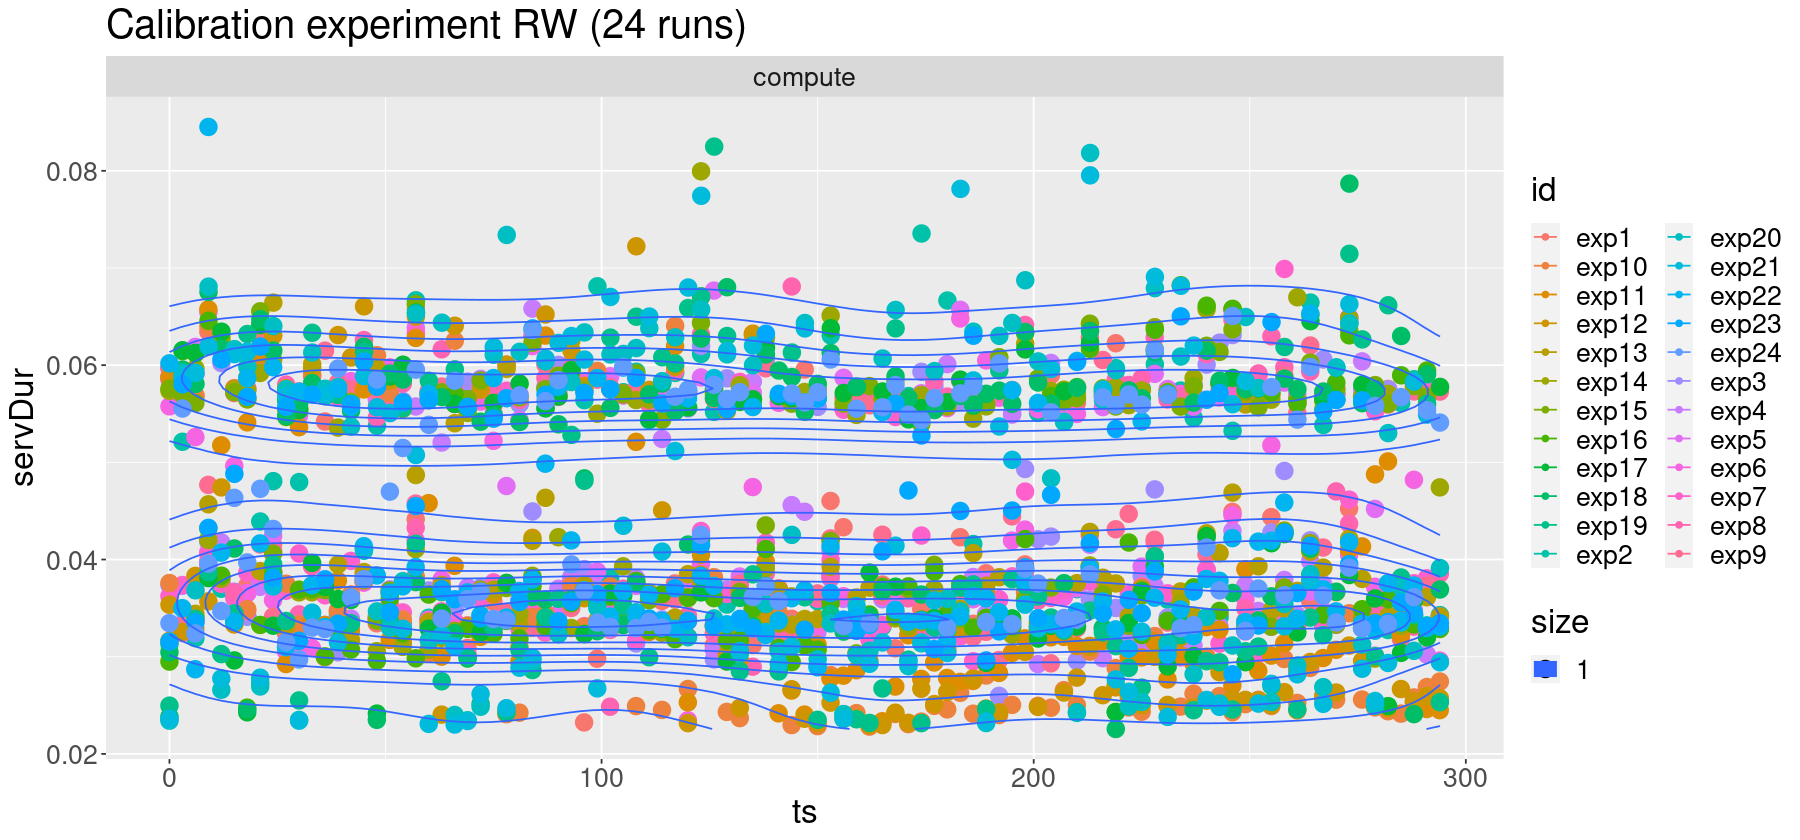

In [73]:
ggplot(dataCalRWDock, aes(x=ts, y=servDur))+
    geom_point(aes(size=1, colour=id))+
    #geom_line(color="blue")+
    facet_wrap("service", scales="free")+
    theme(text = element_text(size = 20))+ 
    geom_density2d()+ 
    ggtitle("Calibration experiment RW (24 runs)")

Discussion: We can clearly observe on the plot 2 bags of points. Some of them are around 0.06s, and the others around 0.03. Why this difference? no idea on my side ^^ given that all run in a container with supposedly the same resources. 

However: 
Min.   :0.02256  
 1st Qu.:0.03326  
 Median :0.03741  
 Mean   :0.04321  
 3rd Qu.:0.05682  
 Max.   :0.08451  
 
Tend to show that the 3rd /4 of values are below 0.56, meaning that most of the points are in between 0.56 and 0.02 with a median at 0.037.

**How to translate that to SimGrid?**

- make several runs, with different flop amounts **in between** the min and max values, and then merge the results
- make single experiments around the median, or close to it.
- use RNG in the microservice to perform the computations in-between an interval


### From real world to a simgrid representation with the same durations

In simgrid, let's consider the capacity of the task instance as N GF. This means our instance can execute N flops per second. We now need to find the amount of flops required to spend 0.32ms computing for each service request.

To do that, just compute: 0.32 * N. If the capacity is 1GF, then services that compute 0.032 GF = 3.2e7 flops should do the same. Let's try this

```
./bench1 ./dejavu_platform.xml 32000000 ../comparison/files/tsCal.csv > logcal_SG_32000000.log 2>&1
awk -f parse.awk logcal_SG_320000000.log > ../comparison/files/SG_results_cal_32000000.csv
```


In [81]:
dataCalSG <- as_tibble(read.csv("files/SG_results_cal_32000000.csv"))
head(dataCalSG)

ts,qArr,instArr,startEx,endEx,flops
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.032,4,4,4,4.032,3.2e+07
7.032,7,7,7,7.032,3.2e+07
10.032,10,10,10,10.032,3.2e+07
13.032,13,13,13,13.032,3.2e+07
16.032,16,16,16,16.032,3.2e+07
19.032,19,19,19,19.032,3.2e+07


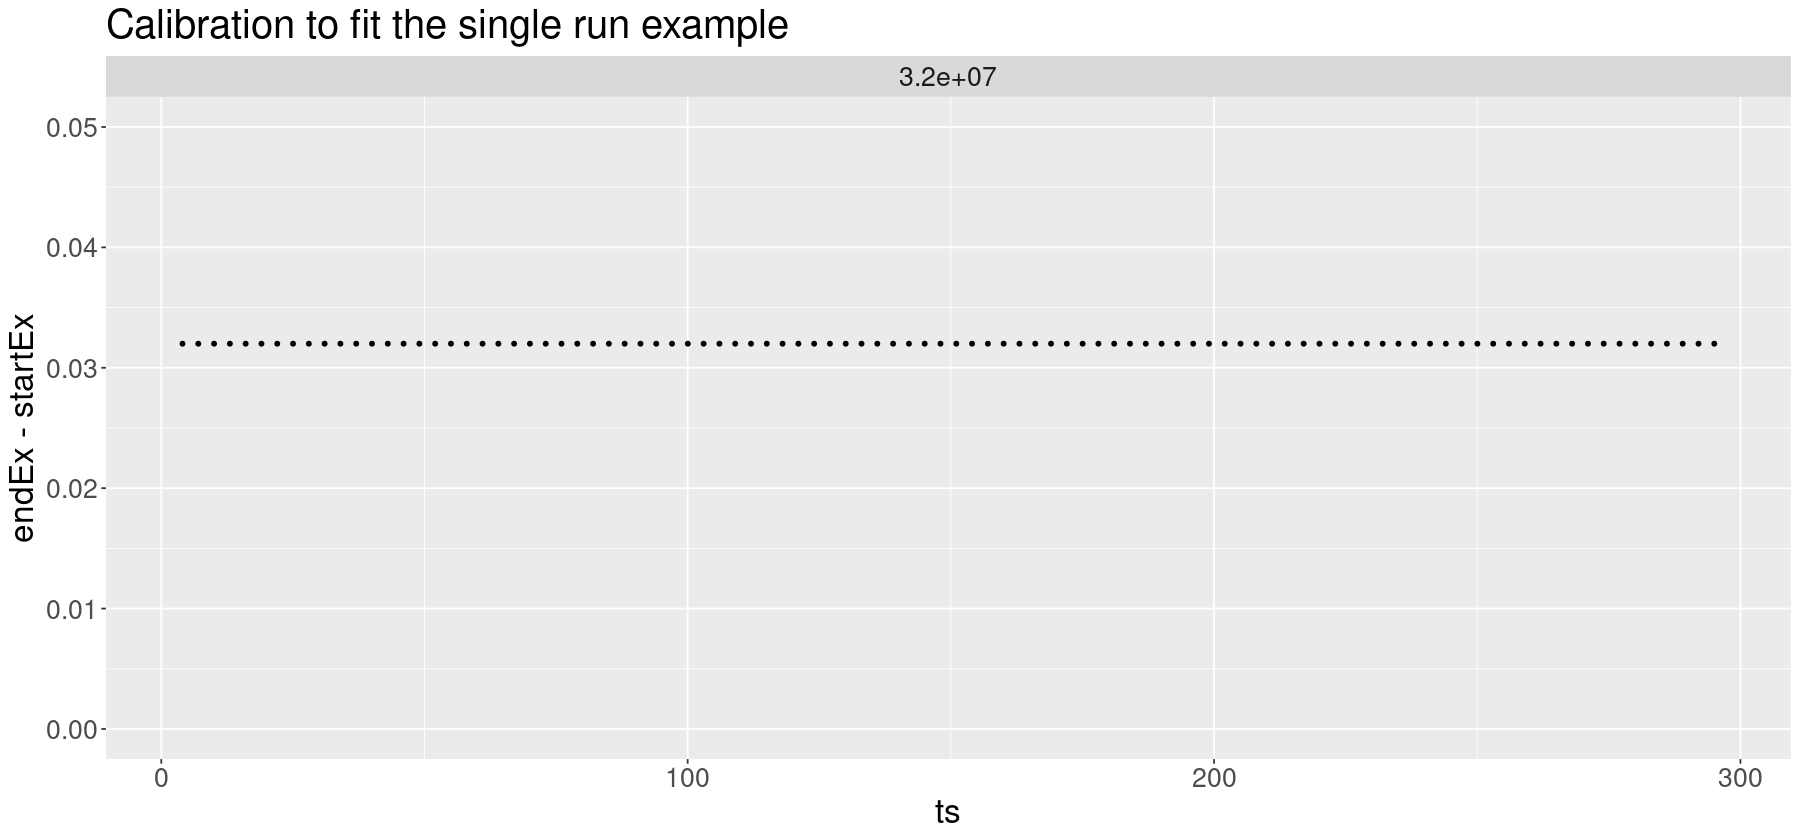

In [82]:
ggplot(dataCalSG, aes(x=ts, y=endEx-startEx))+
    geom_point(size=1)+
    #geom_line(color="blue")+
    facet_wrap("flops", scales="free")+
    theme(text = element_text(size = 20))+
    ylim(0,0.05)+ 
    ggtitle("Calibration to fit the single run example")

We can see that the duration of each requst is exactly 32ms. All times here are exactly the same because we are in the simulation. We have no modeling of external noise which happens in a real system. To observe some changes in execution time, we need to put a more important load. When 2 or more requests will be executed during the same time intervals, you will observe some differences.

# 1st experiment: 1 service 

## Setup, goal and context

The goal of this experiment is to evaluate the accuracy between the execution of a single microservice prototype communicating through rabbitmq (to fetch requests and send the results to a sink), and the execution of the same application in SimGrid under the same loads. Our goal is to obtain similar results between both.

The application is composed of 3 elements. 

- 1 dataSource: the entity that, for every timestamp in the load file, send a request (add to rabbitmq queue of the service in case of the real application, sends a taskDescription object to an ETM in SimGrid).
- 1 service: fetches task requests and executes the work corresponding to the request (1ETM and 1TI in SG, with a given flop amount to execute, fetch one element from the rabbitmq service queue, and loop a given amount of time in a thread for the real execution).
- 1 sink: once services are done executing a task, they send the result back to a sink

```
DATASRC --(RMQ or SG mailboxes comm)--> Service (execute(flops) or loop(nbIt)) --> Sink
```

The goal here is to find a calibration for SG which fits one instance of real world execution.

## Real world

- Code used from commit: https://github.com/klementc/calvin-microbenchmarks/commit/ffe462b305df35e96a93a84ab3c89775f2bd5ca2
- csv of results available in: `files`
- obtained using the `launchCalib.sh` script https://github.com/klementc/calvin-microbenchmarks/commit/614ecb8543a7b0f7c303896316dff5a4d4ad6b83
- launch rabbitmq locally through docker `docker run -d -p 15672:15672 -p 5672:5672 --hostname my-rabbit rabbitmq:3` before execution

**Values for loop iteration amount: 1100000**

- parsed output: files/RW_results_1_1100000.csv
- raw logs: files/RW_logs_1_S1_1_1100000.log

In [42]:
dataRW_1 <- read.csv("files/RW_results_1_1100000.csv")
colnames(dataRW_1) <- c("ts","service","txDur","servDur","wait","nbIter")
str(dataRW_1)
summary(dataRW_1)

my_dataRW_1 <- as_tibble(dataRW_1)
my_dataRW_1

'data.frame':	8709 obs. of  6 variables:
 $ ts     : num  1.61e+09 1.61e+09 1.61e+09 1.61e+09 1.61e+09 ...
 $ service: chr  "compute" "compute" "compute" "compute" ...
 $ txDur  : num  0.00627 0.00226 0.00179 0.0017 0.00136 ...
 $ servDur: num  0.0577 0.1005 0.0504 0.0512 0.0459 ...
 $ wait   : num  0.010666 0.000566 0.000409 0.000357 0.000362 ...
 $ nbIter : num  1100000 1100000 1100000 1100000 1100000 1100000 1100000 1100000 1100000 1100000 ...


       ts              service              txDur              servDur       
 Min.   :1.614e+09   Length:8709        Min.   :0.0003362   Min.   :0.00000  
 1st Qu.:1.614e+09   Class :character   1st Qu.:0.0007188   1st Qu.:0.00000  
 Median :1.614e+09   Mode  :character   Median :0.0015671   Median :0.00000  
 Mean   :1.614e+09                      Mean   :0.0097540   Mean   :0.06775  
 3rd Qu.:1.614e+09                      3rd Qu.:0.0065718   3rd Qu.:0.08150  
 Max.   :1.614e+09                      Max.   :0.2722104   Max.   :0.91046  
                                                                             
      wait               nbIter       
 Min.   :0.0000000   Min.   :1100000  
 1st Qu.:0.0000000   1st Qu.:1100000  
 Median :0.0000000   Median :1100000  
 Mean   :0.0012119   Mean   :1100000  
 3rd Qu.:0.0003004   3rd Qu.:1100000  
 Max.   :0.1347320   Max.   :1100000  
                     NA's   :4355     

ts,service,txDur,servDur,wait,nbIter
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1613742116,compute,0.0062713623,0.05766320,0.0106661320,1100000
1613742116,compute,0.0022573471,0.10050559,0.0005664825,1100000
1613742117,compute,0.0017874241,0.05035353,0.0004086494,1100000
1613742117,compute,0.0017018318,0.05121446,0.0003571510,1100000
1613742117,compute,0.0013630390,0.04594564,0.0003623962,1100000
1613742117,compute,0.0006885529,0.02328444,0.0002102852,1100000
1613742118,compute,0.0018906593,0.03018284,0.0004711151,1100000
1613742118,compute,0.0009906292,0.03455973,0.0002343655,1100000
1613742118,compute,0.0020952225,0.05370212,0.0004577637,1100000


### Compute times per request

For the compute service:

Warning message:
“Removed 49 row(s) containing missing values (geom_path).”
Warning message:
“Removed 30 row(s) containing missing values (geom_path).”


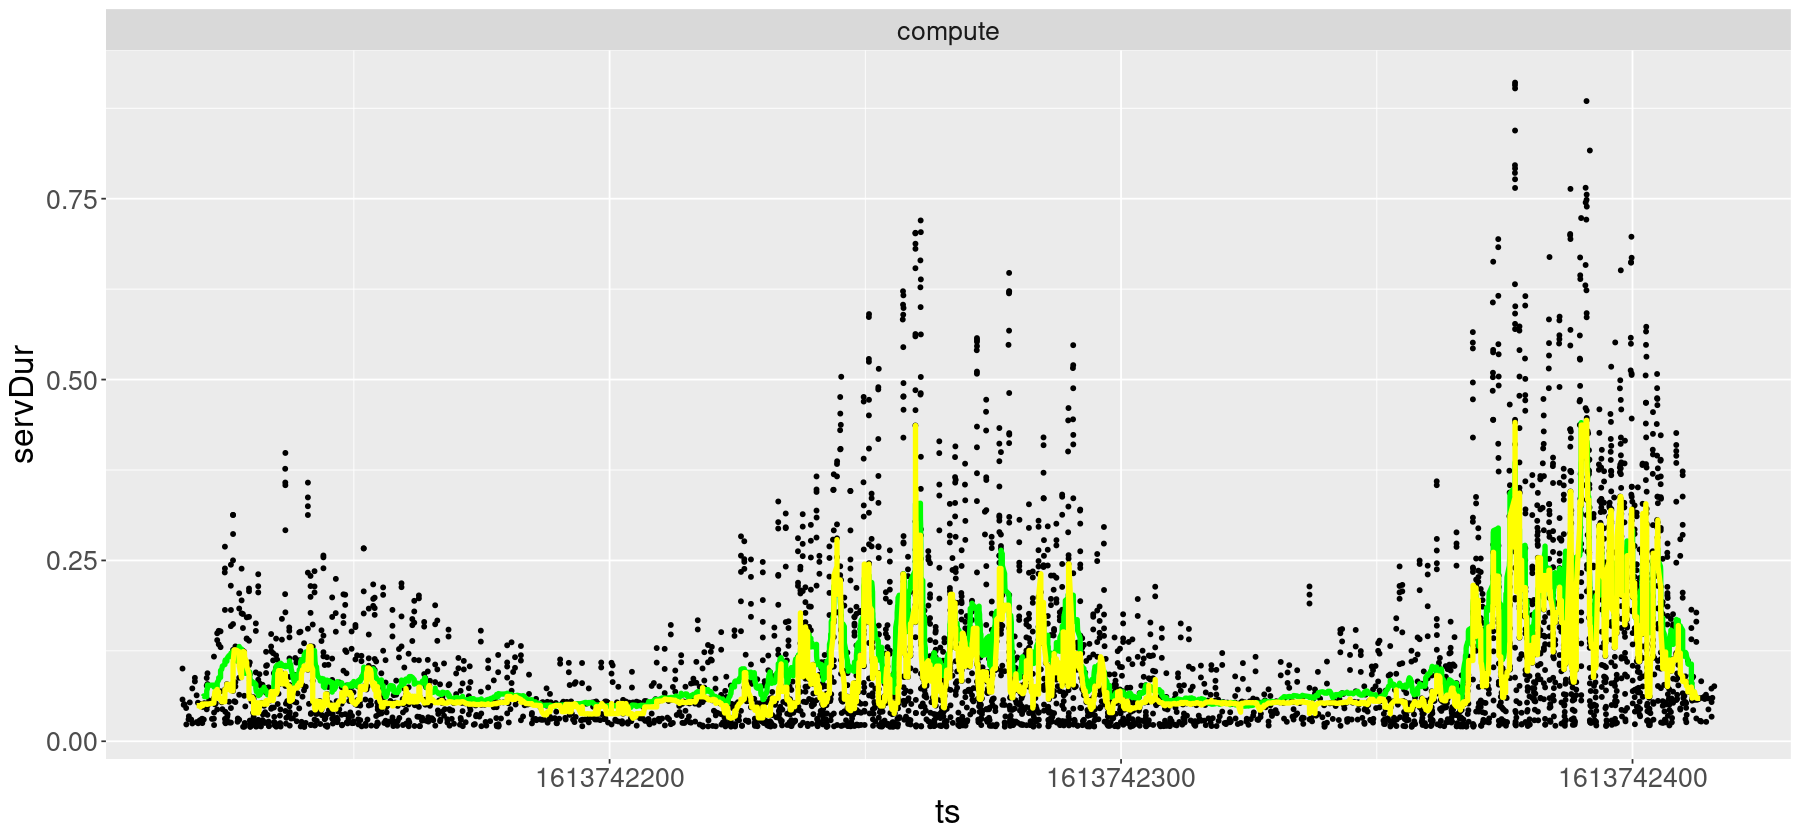

In [50]:
my_dataRW_1_compute <- my_dataRW_1 %>% filter(service == "compute")

ggplot(my_dataRW_1_compute, aes(x=ts, y=servDur))+
    geom_point(size=1)+
    #geom_line(color="blue")+
    facet_wrap("service", scales="free")+
    geom_line(aes(y=rollmean(servDur, 50, na.pad=TRUE)), color="green", size =1.5)+
    geom_line(aes(y=rollmedian(servDur, 31, na.pad=TRUE)), color="yellow", size=1.5)+
    theme(text = element_text(size = 20)) #+ylim(0,0.1)

Time spent in the sink (should be 0 or almost every time because no action is taken other than receiving).

Warning message:
“Removed 49 row(s) containing missing values (geom_path).”
Warning message:
“Removed 30 row(s) containing missing values (geom_path).”


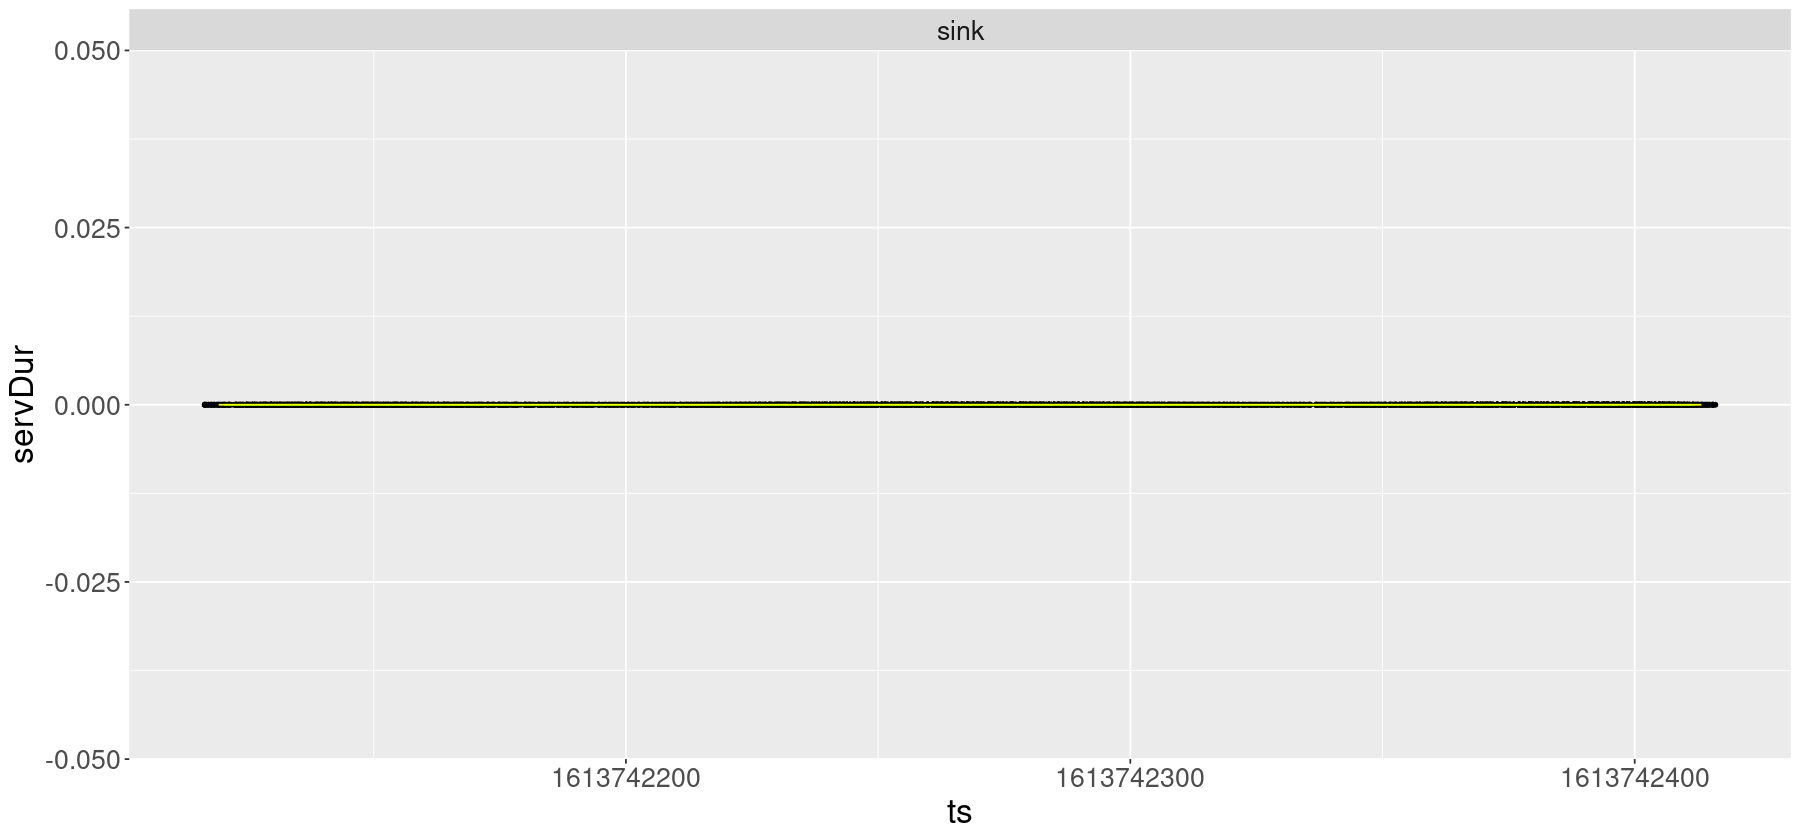

In [81]:
my_dataRW_1_sink <- my_dataRW_1 %>% filter(service == "sink")

ggplot(my_dataRW_1_sink, aes(x=ts, y=servDur))+
    geom_point(size=1)+
    #geom_line(color="blue")+
    facet_wrap("service", scales="free")+
    geom_line(aes(y=rollmean(servDur, 50, na.pad=TRUE)), color="green")+
    geom_line(aes(y=rollmedian(servDur, 31, na.pad=TRUE)), color="yellow")+
    theme(text = element_text(size = 20)) 

### Delay between source and reception.

Given that the rabbitmq service is running on localhost (using the official docker container), transmission times are almost nonexistant. What can be seen is the duration between the instant the packet is sent from the source, and the request is received by the service.

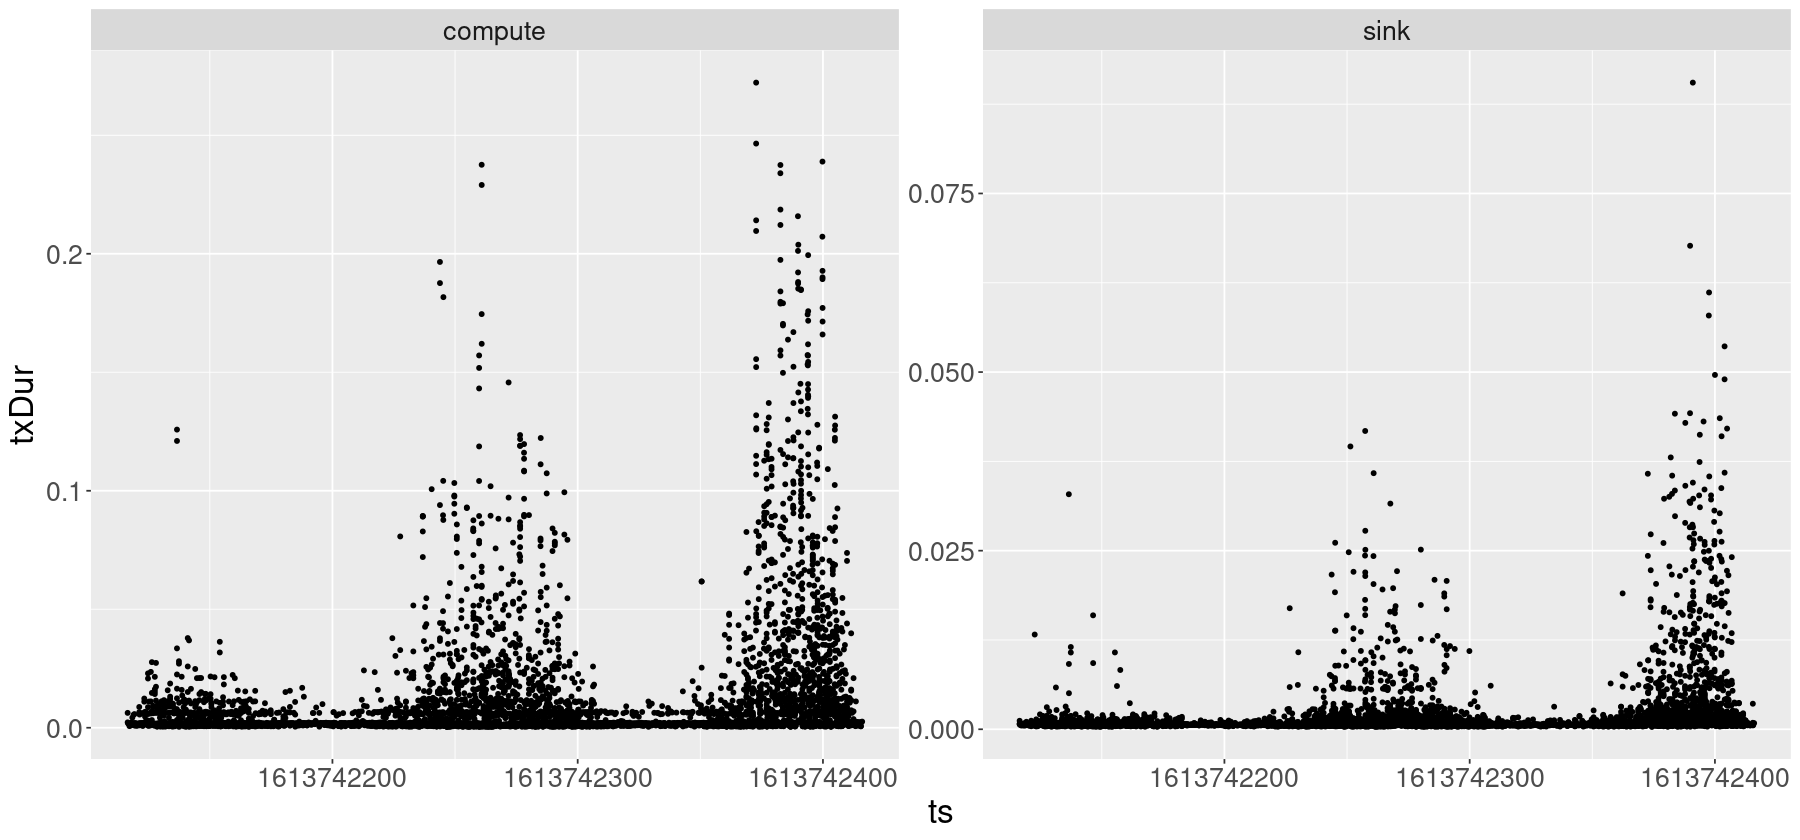

In [78]:
ggplot(my_dataRW_1, aes(x=ts, y=txDur))+
    geom_point(size=1)+
    #geom_line(color="blue")+
    facet_wrap("service", scales="free")+
    theme(text = element_text(size = 20)) 

### SimGrid

We have seen in the previous section that the execution of 1100000 loop iterations took around 0.032s on my laptop and as such, could be modeled by a 3.2e7 flops service. Now we can try to launch the SG simulation using the same previous timestamps.

```
./bench1 ./dejavu_platform.xml 32000000 ../comparison/files/tsload.csv > logload_SG_32000000.log 2>&1
awk -f parse.awk logload_SG_32000000.log > ../comparison/files/SG_results_load_32000000.csv
```

In [29]:
data_loadSG <- as_tibble(read.csv("files/SG_results_load_32000000.csv"))
head(data_loadSG)

ts,qArr,instArr,startEx,endEx,flops
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.499,0.462,0.462,0.462,0.499,3.2e+07
0.526,0.489,0.489,0.489,0.526,3.2e+07
0.763,0.731,0.731,0.731,0.763,3.2e+07
0.912,0.880,0.880,0.880,0.912,3.2e+07
1.251,1.219,1.219,1.219,1.251,3.2e+07
1.310,1.278,1.278,1.278,1.310,3.2e+07


Warning message:
“Removed 49 row(s) containing missing values (geom_path).”
Warning message:
“Removed 30 row(s) containing missing values (geom_path).”


<ScaleContinuousPosition>
 Range:  
 Limits:    0 --  0.5

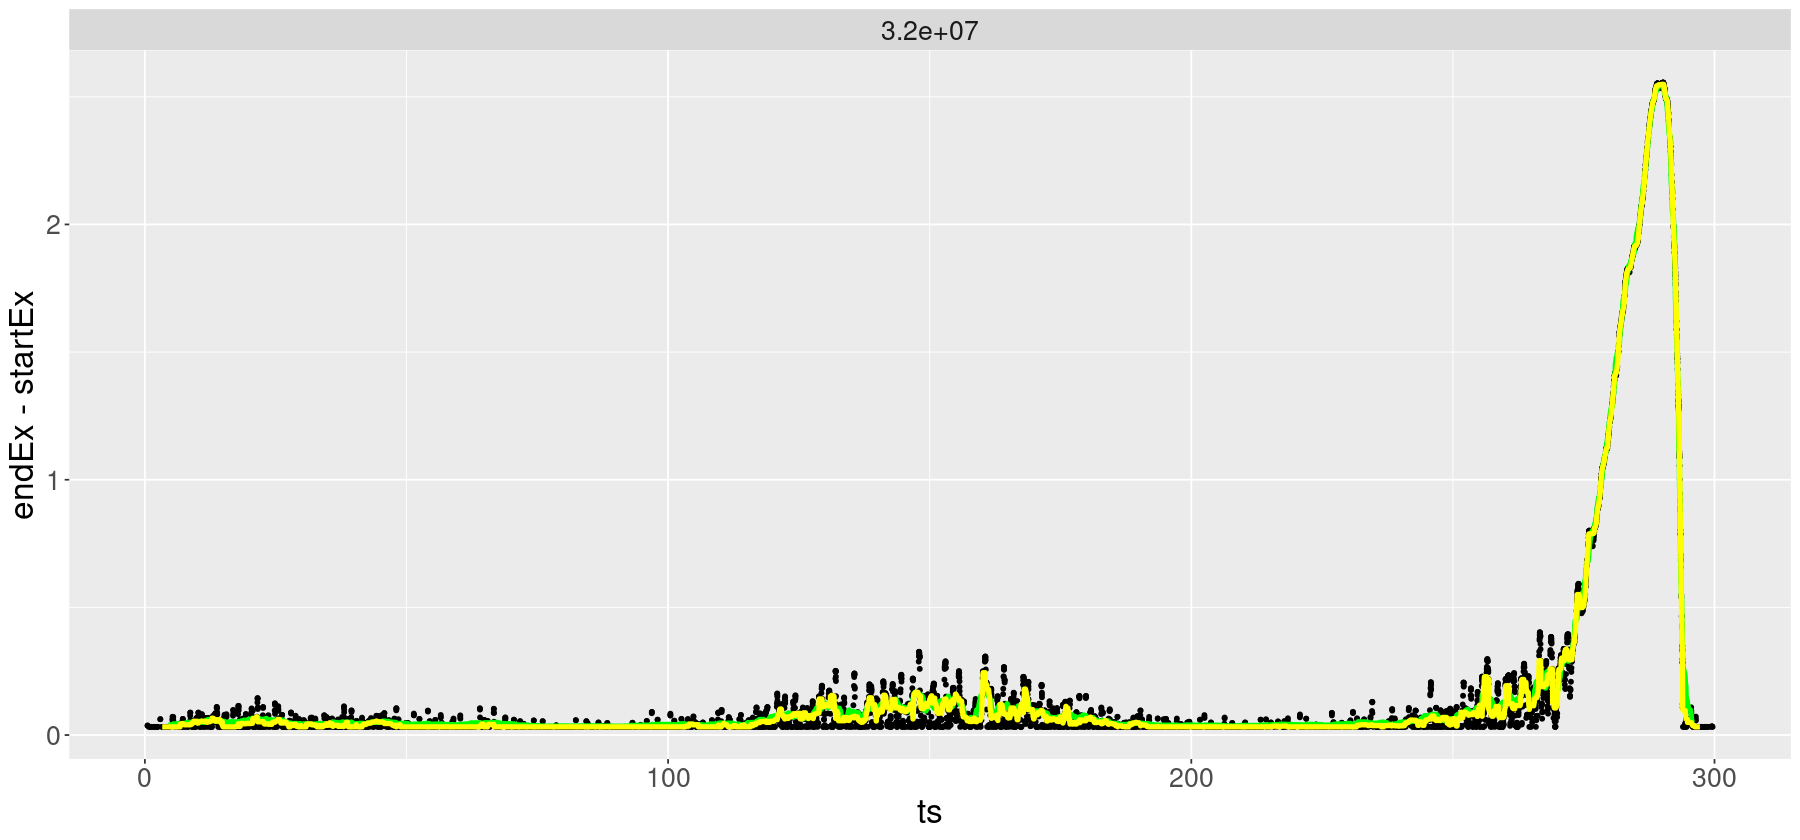

In [48]:
ggplot(data_loadSG, aes(x=ts, y=endEx-startEx))+
    geom_point(size=1)+
    #geom_line(color="blue")+
    facet_wrap("flops", scales="free")+
    theme(text = element_text(size = 20))+
    geom_line(aes(y=rollmean(endEx-startEx, 50, na.pad=TRUE)), color="green", size=1.5)+
    geom_line(aes(y=rollmedian(endEx-startEx, 31, na.pad=TRUE)), color="yellow", size=1.5)
    ylim(0,.5)